In [1]:
import tensorflow as tf
import os
from tools import minMaxScale, wavelength2rgb
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import cv2
from src.models.ig_cnn import ig_cnn_model, get_cnn_dataset

* [How connect spectrum](www.fourmilab.ch/documents/specrend/)
* [Python library](https://python-colormath.readthedocs.io/en/latest/color_objects.html#spectralcolor)



In [13]:
from tensorflow import keras
class InformationGainCallback(keras.callbacks.Callback):
    def __init__(self, input_image, target_image):
        super(InformationGainCallback, self).__init__()
        # Create batch dimension expects [width, height, channels]
        self.inputs = np.expand_dims(input_image, 0)
        self.outputs = target_image
    def gain(self):
        # calculate gain and print it out
        gain = abs(self.outputs - self.model.predict(self.inputs)) / (self.outputs.shape[0] * self.outputs.shape[1])
        return gain.flatten().max()


    def on_epoch_end(self, epoch, logs=None):
        print(f"Information gain:  {self.gain()}")

In [17]:
# Parameters
image_path = '../data/raw/still_life/sample_22.mat'
model_def = "C-25-5-sigmoid-valid,C-25-1-sigmoid-same"
log_root = os.path.join('..', 'logs')
# Input Data
inputs, outputs, pad_output, nopad_input = get_cnn_dataset(image_path, input_size=5)
# Model Definition
model = ig_cnn_model(model_def)
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

log_dir = os.path.join(log_root, model.name)
# Data split
training_set_size = 2500
perm = np.random.permutation(inputs.shape[0])
ins = inputs[perm[:training_set_size], :]
outs = outputs[perm[:training_set_size], :]

callbacks = [tf.keras.callbacks.TensorBoard(log_dir=log_dir),
             InformationGainCallback(input_image=nopad_input, target_image=pad_output),
             # NOTE: This callback has to be last
             tf.keras.callbacks.EarlyStopping(patience=6, min_delta=10 ** -5),
 ]
history = model.fit(ins,
                    outs,
                    epochs=100,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=callbacks
                    )

Train on 2000 samples, validate on 500 samples
Epoch 1/100
2000/2000 [==============================] - 0s 150us/sample - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 2/100
2000/2000 [==============================] - 0s 50us/sample - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 3/100
2000/2000 [==============================] - 0s 50us/sample - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 4/100
2000/2000 [==============================] - 0s 51us/sample - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 5/100
2000/2000 [==============================] - 0s 48us/sample - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 6/100
2000/2000 [==============================] - 0s 49us/sample - loss: 0.0039 - mean_squared_error: 0.0

In [12]:
print(model.predict(inputs).shape)
print(outputs.shape)
# calculate gain and print it out
gain = abs(outputs - model.predict(inputs)) / (outputs.shape[0] * outputs.shape[1])
print('Gain: {:1.4e}'.format(gain.flatten().max()))

(157609, 1, 1, 1)
(157609, 1, 1, 1)
Gain: 3.4917e-06


In [7]:
extrapolation = model.predict(inputs)
approx = extrapolation.reshape(pad_output.shape)

diff = (pad_output-approx) - np.min(pad_output-approx)
diff = diff/np.max(diff)

imgs = np.concatenate([pad_output, approx, diff], axis=1)
cv2.imshow('Target | Approx | Gamma corr', imgs)
cv2.waitKey(0)
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [ ]:
extrapolation = model.predict(inputs)
approx = extrapolation.reshape(target.shape)

diff = minMaxScale(target - approx)

imgs = np.concatenate(
    [ np.concatenate([target, approx], axis=1),
    np.concatenate([diff, diff], axis=1)],
    axis=0)
cv2.imshow('Target | Approx | Gamma corr', imgs)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [11]:
model.predict(np.expand_dims(pad_input, 0))


#abs(pad_output - model.predict(pad_input)) / (pad_output.shape[0] * pad_output.shape[1])

array([[[[0.32500917],
         [0.3242013 ],
         [0.3244878 ],
         ...,
         [0.34974533],
         [0.35286796],
         [0.3539608 ]],

        [[0.32433215],
         [0.32388932],
         [0.3246518 ],
         ...,
         [0.35164183],
         [0.35522738],
         [0.3561613 ]],

        [[0.3249613 ],
         [0.32445645],
         [0.32596081],
         ...,
         [0.34971434],
         [0.35425273],
         [0.35611975]],

        ...,

        [[0.35422426],
         [0.35164732],
         [0.35139045],
         ...,
         [0.38294953],
         [0.38346165],
         [0.3840891 ]],

        [[0.35493088],
         [0.3539242 ],
         [0.35327524],
         ...,
         [0.38290843],
         [0.38263816],
         [0.38319242]],

        [[0.35538644],
         [0.35391498],
         [0.3529947 ],
         ...,
         [0.3816158 ],
         [0.38225144],
         [0.38352638]]]], dtype=float32)

In [34]:
image_path = '../data/raw/still_life/allChannels.mat'
image = sio.loadmat(image_path)['sl']

'..\\logs'

In [35]:
plt.imshow(wavelength2rgb(image[:, :, :16] / 255.0))
plt.imsave('still_life.png',wavelength2rgb(image[:, :, :16] / 255.0))

In [22]:
plt.imshow(image[:,:,26], cmap='gray')

 Volume in drive C is Windows
 Volume Serial Number is DE3B-991C

 Directory of C:\Users\Tomas Karella\Desktop\igre\notebooks

12/06/2020  12:30 PM    <DIR>          .
12/06/2020  12:30 PM    <DIR>          ..
11/21/2020  11:11 PM                 0 .gitkeep
11/21/2020  11:11 PM            23,178 01-igre-by-CNN-debug.ipynb
11/21/2020  11:11 PM         6,470,751 02-saul-decorrelation.ipynb
12/02/2020  03:32 PM           332,332 image.png
12/02/2020  03:30 PM           332,332 image2.png
12/02/2020  03:32 PM           334,602 image3.png
12/06/2020  12:29 PM    <DIR>          logs
12/02/2020  06:01 PM         2,469,659 still_life.png
12/06/2020  12:30 PM           376,759 tk-cnn.ipynb
12/02/2020  06:30 PM           246,380 tk-test.ipynb
12/02/2020  03:47 PM             2,947 tools.py
12/02/2020  05:52 PM    <DIR>          __pycache__
              10 File(s)     10,588,940 bytes
               4 Dir(s)  103,799,005,184 bytes free


In [244]:
plt.imsave('../data/raw/still_life/sample_22_CNN.png',np.squeeze(diff), cmap='gray')

In [17]:
keras.metrics.Metric?


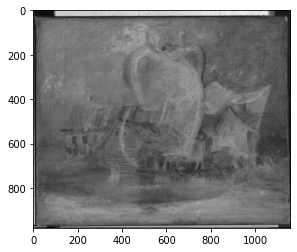

In [257]:
plt.imshow(image[:,:,26], cmap='gray')

In [266]:
plt.imsave('../data/raw/still_life/sample_22_CNN.png',np.squeeze(diff), cmap='gray')